## Cal-CRAI Supplementary Layer: Sea Level Rise Impact Area

In the SLR focused scenario, we intentionally need to set inland census tracts / counties as "improbable" or "invulnerable" to the particular risk. For our purposes, we define the areas of vulnerability to SLR based on the Cal-CRAI metric: `percent change in wetland habitat under RCP 4.5 at median model SLR per county`. From this metric, we create a binary layer of: **At risk to SLR = 1** and **Not at risk to SLR = 0**, where all census tracts (via their respective county) at risk to SLR are identified as having a non-missing percent change in wetland habitat due to SLR. 

This "improbability" layer is used to mask all in-land counties in the SLR focused scenario analysis, to avoid in-land values skewing the overall distribution of values. The first half of this notebook is similar to the metric calculation for the input layer. 

In [2]:
import os
import sys
import pandas as pd
import io
import numpy as np
import geopandas as gpd

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import add_census_tracts

## Step 1: Pull data and process metric

In [3]:
bucket_name = 'ca-climate-index'
aws_dir = '1_pull_data/climate_risk/sea_level_rise/loss/climate_central/'
output_folder = '../data_metric_calc'

pull_csv_from_directory(bucket_name, aws_dir, output_folder=output_folder, search_zipped=False)

Saved DataFrame as '../data_metric_calc/RCP_wetland_data.csv'


In [4]:
wetland_data = pd.read_csv('RCP_wetland_data.csv')

In [5]:
# Adjust the data
adjusted_wetland_data = wetland_data[22:]

# Set the first row as the header and reset index
adjusted_wetland_data.columns = adjusted_wetland_data.iloc[0]
adjusted_wetland_data = adjusted_wetland_data[1:].reset_index(drop=True)

# Drop the index column if it has been set as a column
adjusted_wetland_data.reset_index(drop=True, inplace=True)

# Rename columns to ensure no extra index is included
adjusted_wetland_data.columns.name = None

# Filter columns explicitly
columns_to_keep = [col for col in adjusted_wetland_data.columns 
                    if 'County' in col or '2000' in col or '2100' in col]
adjusted_wetland_data = adjusted_wetland_data[columns_to_keep]
adjusted_wetland_data.columns

Index(['County', 'RCP_2.6__5th_percentile__2000',
       'RCP_2.6__50th_percentile__2000', 'RCP_2.6__95th_percentile__2000',
       'RCP_4.5__5th_percentile__2000', 'RCP_4.5__50th_percentile__2000',
       'RCP_4.5__95th_percentile__2000', 'RCP_8.5__5th_percentile__2000',
       'RCP_8.5__50th_percentile__2000', 'RCP_8.5__95th_percentile__2000',
       'RCP_2.6__5th_percentile__2100', 'RCP_2.6__50th_percentile__2100',
       'RCP_2.6__95th_percentile__2100', 'RCP_4.5__5th_percentile__2100',
       'RCP_4.5__50th_percentile__2100', 'RCP_4.5__95th_percentile__2100',
       'RCP_8.5__5th_percentile__2100', 'RCP_8.5__50th_percentile__2100',
       'RCP_8.5__95th_percentile__2100'],
      dtype='object')

In [6]:
# Function to calculate percent change between 2000 and 2100 columns
def calculate_percent_change(data, leave_alone=[]):
    # Convert columns to numeric, forcing non-numeric to NaN (skip columns in leave_alone)
    numeric_data = data.copy()
    for col in data.columns:
        if col not in leave_alone:
            numeric_data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Define columns for 2000 and 2100
    cols_2000 = [col for col in numeric_data.columns if '2000' in col]
    cols_2100 = [col for col in numeric_data.columns if '2100' in col]
    
    # Calculate percent change
    percent_change = pd.DataFrame()

    for cols_2000 in cols_2000:
        # Find the matching 2100 column
        col_2100 = cols_2000.replace('2000', '2100')

        if col_2100 in cols_2100:
            # Calculate percent change, handling NaN values
            percent_change[cols_2000 + '_to_' + col_2100] = (
                (numeric_data[col_2100] - numeric_data[cols_2000]) / numeric_data[cols_2000]
            ) * 100
    
    # Concatenate the percent change DataFrame with the original numeric data
    result = pd.concat([numeric_data, percent_change], axis=1)
    
    return result

# Function to rename columns, allowing some to be left unchanged
def rename_columns(data, leave_alone=[]):
    def rename_column(col):
        if col in leave_alone:
            return col
        words = col.split('_')
        return '_'.join(words[:4]) + '_percent_change'
    
    # Apply renaming function to columns
    data.columns = [rename_column(col) for col in data.columns]
    return data

# List of columns to leave unchanged
column_leave_alone = ['County']

In [7]:
# Run the calculation and renaming
adjusted_wetland_metric = calculate_percent_change(adjusted_wetland_data, leave_alone=column_leave_alone)

# Filter for columns that contain 'County' or 'to'
filtered_columns = [col for col in adjusted_wetland_metric.columns if 'County' in col or 'to' in col]

# Create a new DataFrame with only the filtered columns
filtered_wetland_metric = adjusted_wetland_metric[filtered_columns]
# Remove duplicate columns
filtered_wetland_metric = filtered_wetland_metric.loc[:, ~filtered_wetland_metric.columns.duplicated()]

wetland_metric_percent_change = rename_columns(filtered_wetland_metric, leave_alone=column_leave_alone)

wetland_metric_percent_change.columns = wetland_metric_percent_change.columns.str.lower()
wetland_metric_percent_change = wetland_metric_percent_change.applymap(lambda s: s.lower() if type(s) == str else s)

# Display the resulting DataFrame
wetland_metric_percent_change.head(3)

,county,rcp_2.6__5th_percent_change,rcp_2.6__50th_percent_change,rcp_2.6__95th_percent_change,rcp_4.5__5th_percent_change,rcp_4.5__50th_percent_change,rcp_4.5__95th_percent_change,rcp_8.5__5th_percent_change,rcp_8.5__50th_percent_change,rcp_8.5__95th_percent_change
0,alameda,0.0,-0.498753,-16.708229,0.0,-3.740648,-21.945137,-0.498753,-10.723192,-38.902743
1,alpine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,amador,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# read in CA census tiger file
ca_tract_county = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_tract_county = gpd.read_file(ca_tract_county)
ca_tract_county = ca_tract_county.drop(columns={'field_1'})
ca_tract_county.columns = ca_tract_county.columns.str.lower()
ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)

ca_tract_county.head(3)

,tract,countyfp,county
0,06085504321,085,santa clara
1,06085504410,085,santa clara
2,06085507003,085,santa clara


In [9]:
wetland_metric_merge = pd.merge(ca_tract_county, wetland_metric_percent_change, on='county', how='left')
final_columns = ['tract', 'county', 'rcp_4.5__50th_percent_change']
wetland_metric_final = wetland_metric_merge[final_columns]
wetland_metric_final['GEOID'] = wetland_metric_final['tract']
wetland_metric_final.drop(columns=['tract'])

/var/folders/6g/b2z199kx72x11z3xdvsz3ytr0000gn/T/ipykernel_59066/2344416328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wetland_metric_final['GEOID'] = wetland_metric_final['tract']


,county,rcp_4.5__50th_percent_change,GEOID
0,santa clara,-4.854369,06085504321
1,santa clara,-4.854369,06085504410
2,santa clara,-4.854369,06085507003
3,santa clara,-4.854369,06085507004
4,santa clara,-4.854369,06085502204
...,...,...,...
9124,orange,-5.952381,06059001303
9125,orange,-5.952381,06059001304
9126,orange,-5.952381,06059001401
9127,contra costa,-7.142857,06013367200


In [10]:
gdf = add_census_tracts(wetland_metric_final)
gdf.head(5)

,tract,county,rcp_4.5__50th_percent_change,GEOID,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06085504321,santa clara,-4.854369,06085504321,06,085,504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,santa clara,-4.854369,06085504410,06,085,504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,santa clara,-4.854369,06085507003,06,085,507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02458 37.2..."
3,06085507004,santa clara,-4.854369,06085507004,06,085,507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,santa clara,-4.854369,06085502204,06,085,502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."


## Step 2: Identify SLR regions and create binary layer

In [11]:
# counties not impacted by SLR
no_impact_counties = gdf.loc[gdf['rcp_4.5__50th_percent_change'].isnull()]['county'].unique().tolist()
print('# of non-impacted census tracts: ', len(gdf.loc[gdf['rcp_4.5__50th_percent_change'].isnull()]))
no_impact_counties

# of non-impacted census tracts:  2306


['kern',
 'san bernardino',
 'el dorado',
 'placer',
 'riverside',
 'sutter',
 'tulare',
 'alpine',
 'stanislaus',
 'trinity',
 'amador',
 'fresno',
 'tehama',
 'merced',
 'butte',
 'lake',
 'madera',
 'lassen',
 'imperial',
 'mariposa',
 'nevada',
 'yuba',
 'tuolumne',
 'calaveras',
 'shasta',
 'siskiyou',
 'san benito',
 'plumas',
 'sierra',
 'kings',
 'colusa',
 'modoc',
 'inyo',
 'glenn',
 'mono']

In [12]:
# slr impacted counties
impact_counties = gdf.loc[gdf['rcp_4.5__50th_percent_change'] < 100]['county'].unique().tolist()
print('# of SLR impacted census tracts: ', len(gdf.loc[gdf['rcp_4.5__50th_percent_change'] < 100]))
impact_counties

# of SLR impacted census tracts:  6823


['santa clara',
 'orange',
 'alameda',
 'napa',
 'san francisco',
 'monterey',
 'contra costa',
 'los angeles',
 'san joaquin',
 'sacramento',
 'sonoma',
 'del norte',
 'ventura',
 'santa barbara',
 'yolo',
 'san mateo',
 'solano',
 'san luis obispo',
 'san diego',
 'marin',
 'santa cruz',
 'humboldt',
 'mendocino']

Create new binary layer of SLR impact

In [13]:
# need to save a new binary layer of SLR imapct
gdf['slr_impacted'] = gdf['rcp_4.5__50th_percent_change'].apply(lambda x: 1 if not pd.isnull(x) else 0)
gdf.head(10)

,tract,county,rcp_4.5__50th_percent_change,GEOID,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,slr_impacted
0,06085504321,santa clara,-4.854369,06085504321,06,085,504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3...",1
1,06085504410,santa clara,-4.854369,06085504410,06,085,504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4...",1
2,06085507003,santa clara,-4.854369,06085507003,06,085,507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02458 37.2...",1
3,06085507004,santa clara,-4.854369,06085507004,06,085,507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2...",1
4,06085502204,santa clara,-4.854369,06085502204,06,085,502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3...",1
5,06085502203,santa clara,-4.854369,06085502203,06,085,502203,5022.03,Census Tract 5022.03,G5020,S,643887,0,+37.3063756,-121.9180681,"POLYGON ((-121.92296 37.30281, -121.92296 37.3...",1
6,06085501902,santa clara,-4.854369,06085501902,06,085,501902,5019.02,Census Tract 5019.02,G5020,S,1064609,0,+37.3162127,-121.9087833,"POLYGON ((-121.91513 37.31435, -121.91511 37.3...",1
7,06085502104,santa clara,-4.854369,06085502104,06,085,502104,5021.04,Census Tract 5021.04,G5020,S,770515,0,+37.3061059,-121.9278721,"POLYGON ((-121.93179 37.31045, -121.93179 37.3...",1
8,06085502103,santa clara,-4.854369,06085502103,06,085,502103,5021.03,Census Tract 5021.03,G5020,S,1029808,0,+37.3133200,-121.9236600,"POLYGON ((-121.93184 37.31695, -121.93168 37.3...",1
9,06085504424,santa clara,-4.854369,06085504424,06,085,504424,5044.24,Census Tract 5044.24,G5020,S,25455452,119350,+37.4524963,-121.8635532,"POLYGON ((-121.90392 37.46454, -121.90376 37.4...",1


In [14]:
# confirming count of impacted slr tracts
gdf.slr_impacted.value_counts()

slr_impacted
1    6823
0    2306
Name: count, dtype: int64

In [15]:
# clean up before export
gdf = gdf[['GEOID', 'county', 'geometry', 'COUNTYFP', 'slr_impacted']]

<Axes: >

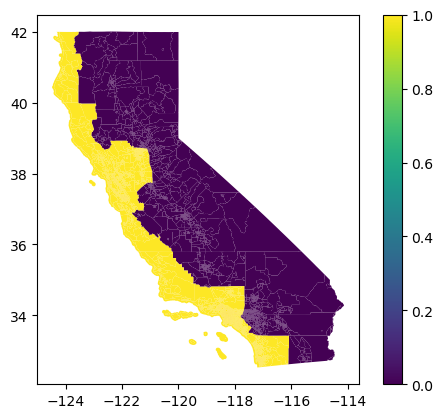

In [16]:
# visually confirm coastal areas have value of 1, inland areas have value of 0 
gdf.plot(column='slr_impacted', legend=True)

## Step 3: Export binary layer

In [17]:
# save layer as csv file
gdf.to_csv('../utils/slr_mask_layer.csv')

In [25]:
# upload to AWS
bucket_name = 'ca-climate-index'
directory = '0_map_data'
export_filename = ['slr_mask_layer.csv']

upload_csv_aws(export_filename, bucket_name, directory) 

slr_mask_layer.csv uploaded to AWS
